In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, jaccard_score,
    confusion_matrix, roc_curve, auc, classification_report
)


In [3]:

df = pd.read_csv('Cancer_Data.csv')
print("Loaded dataset with shape:", df.shape)
print("Columns:", df.columns.tolist())


Loaded dataset with shape: (569, 33)
Columns: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']


In [10]:
possible_targets = ['diagnosis', 'target', 'label', 'Outcome', 'Class', 'class']
target_col = None
for t in possible_targets:
    if t in df.columns:
        target_col = t
        break
if target_col is None:
    target_col = df.columns[-1]  # fallback
print("Target column detected:", target_col, "\n")

Target column detected: diagnosis 



In [11]:
drop_candidates = ['id', 'ID', 'Id', 'patient_id']
for c in drop_candidates:
    if c in df.columns:
        df = df.drop(columns=c)
        print(f"Dropped column: {c}")

X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

# Encode categorical labels (e.g., benign/malignant)
if y.dtype == object or y.dtype.name == 'category':
    le = LabelEncoder()
    y = le.fit_transform(y)
    print("Label encoding applied:", dict(zip(le.classes_, le.transform(le.classes_))))
else:
    y = y.astype(int)

# Encode categorical features if any
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print("Encoding non-numeric features:", non_numeric)
    X = pd.get_dummies(X, drop_first=True)


Label encoding applied: {'B': np.int64(0), 'M': np.int64(1)}


In [16]:
print("🔍 Checking missing values before cleaning...")
total_missing = X.isna().sum().sum()
if total_missing > 0:
    print(f"⚠ Found {total_missing} missing values. Filling with column means...")
    X = X.fillna(X.mean(numeric_only=True))
else:
    print("✅ No missing values found initially.")

# Double-check after mean fill — replace any still missing (from dummy columns)
X = X.fillna(0)
print("✅ All missing values handled successfully.\n")

# Verify no NaNs remain
assert not np.isnan(X.values).any(), "❌ Still found NaN in X after cleaning!"
print("🧼 Verified: No NaN values remain in feature matrix.\n")

🔍 Checking missing values before cleaning...
⚠ Found 569 missing values. Filling with column means...
✅ All missing values handled successfully.

🧼 Verified: No NaN values remain in feature matrix.



In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
kernels = {
    'Linear': {'kernel': 'linear'},
    'Polynomial': {'kernel': 'poly', 'degree': 3},
    'RBF': {'kernel': 'rbf'},
    'Sigmoid': {'kernel': 'sigmoid'}
}

models = {}
for name, params in kernels.items():
    models[name] = SVC(probability=True, random_state=42, **params)


🧠 Training SVM with Linear kernel...
📊 Linear Kernel Metrics:
Accuracy: 0.9649
Recall: 0.9062
Precision: 1.0000
Jaccard Score: 0.9062
Error Rate: 0.0351
Confusion Matrix:
 [[107   0]
 [  6  58]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171


🧠 Training SVM with Polynomial kernel...
📊 Polynomial Kernel Metrics:
Accuracy: 0.8830
Recall: 0.6875
Precision: 1.0000
Jaccard Score: 0.6875
Error Rate: 0.1170
Confusion Matrix:
 [[107   0]
 [ 20  44]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91       107
           1       1.00      0.69      0.81        64

    accuracy                           0.88       171
   ma

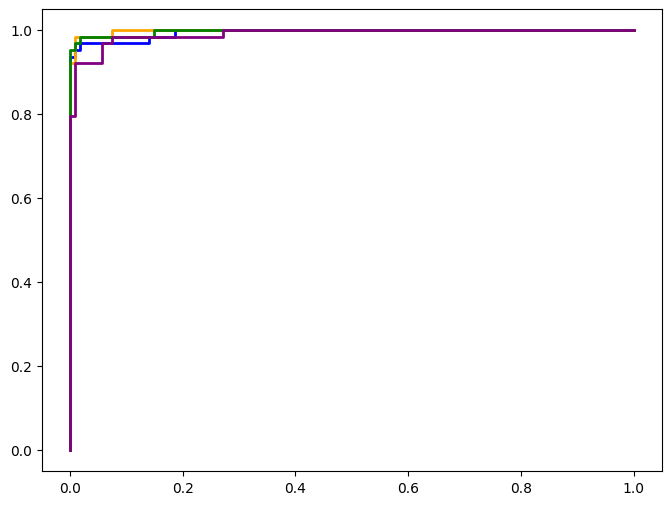

In [19]:
results = []

plt.figure(figsize=(8, 6))
colors = {'Linear': 'blue', 'Polynomial': 'orange', 'RBF': 'green', 'Sigmoid': 'purple'}

for name, model in models.items():
    print("\n" + "=" * 60)
    print(f"🧠 Training SVM with {name} kernel...")
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, zero_division=0)
    prec = precision_score(y_test, y_pred, zero_division=0)
    jacc = jaccard_score(y_test, y_pred, zero_division=0)
    err_rate = 1 - acc
    cm = confusion_matrix(y_test, y_pred)

    print(f"📊 {name} Kernel Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Jaccard Score: {jacc:.4f}")
    print(f"Error Rate: {err_rate:.4f}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[name], lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

    results.append({
        'Kernel': name,
        'Accuracy': acc,
        'Recall': rec,
        'Precision': prec,
        'Jaccard': jacc,
        'ErrorRate': err_rate,
        'AUC': roc_auc,
        'ConfusionMatrix': cm
    })

/tmp/ipython-input-2702398277.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


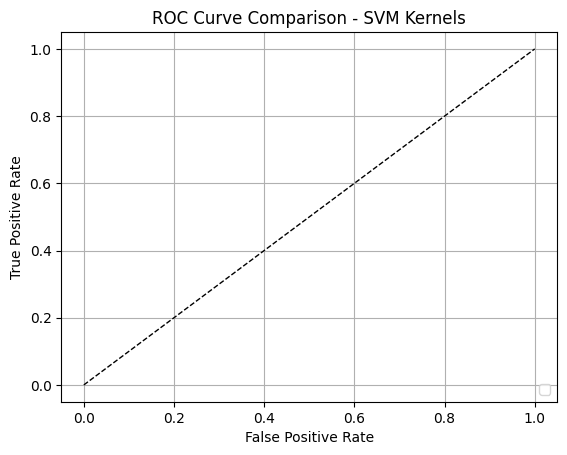

In [20]:
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison - SVM Kernels")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [21]:
results_df = pd.DataFrame([{
    'Kernel': r['Kernel'],
    'Accuracy': r['Accuracy'],
    'Recall': r['Recall'],
    'Precision': r['Precision'],
    'Jaccard': r['Jaccard'],
    'ErrorRate': r['ErrorRate'],
    'AUC': r['AUC']
} for r in results]).set_index('Kernel')

print("\n✅ Summary of all SVM models:\n")
display(results_df)


✅ Summary of all SVM models:



,Accuracy,Recall,Precision,Jaccard,ErrorRate,AUC
Kernel,,,,,,
Linear,0.964912,0.906250,1.000000,0.906250,0.035088,0.994451
Polynomial,0.883041,0.687500,1.000000,0.687500,0.116959,0.998248
RBF,0.959064,0.890625,1.000000,0.890625,0.040936,0.997225
Sigmoid,0.959064,0.921875,0.967213,0.893939,0.040936,0.990800


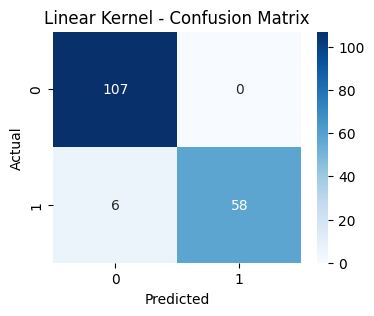

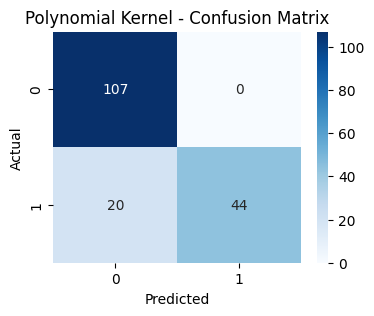

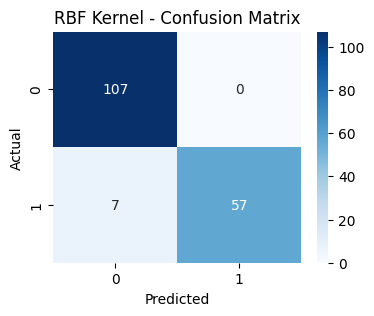

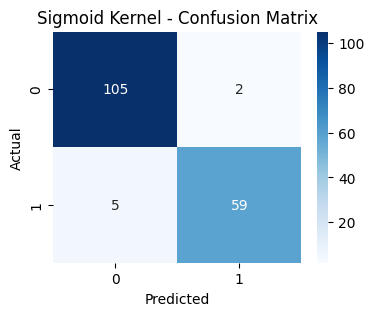


 All models trained and evaluated successfully!


In [22]:
for r in results:
    plt.figure(figsize=(4, 3))
    sns.heatmap(r['ConfusionMatrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"{r['Kernel']} Kernel - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

print("\n All models trained and evaluated successfully!")